## Test Linear Regression Model

In [31]:

import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
plt.switch_backend('TkAgg')


PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

from my_packages.neural_network.data_generators.magnetic_array_generator import RandomMagneticDipoleGenerator

# torch import 
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))


# set all the seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)


cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7f45282624a0>
the device name is:  NVIDIA T600 Laptop GPU


In [2]:

class DataIterator:
    def __init__(self, generating_class, normalize=True):
        self.gen = generating_class
        self.normalize = normalize

    def __iter__(self):
        return self

    def __next__(self):
        labeled_data = self.gen.generate_labeled_data()
        
        if self.normalize:
            labeled_data = self._normalize_data(labeled_data)
        
        return labeled_data

    def _normalize_data(self, labeled_data):
        f, t = labeled_data
        if np.sum(t) == 0:
            return labeled_data
        min_value = np.min(f)
        max_value = np.max(f)
        normalized_f = (f - min_value) / (max_value - min_value)
        return normalized_f, t
    
    def generate_N_data_samples(self, N):
        f = []
        t = []
        for _ in range(N):
            samplef, samplet = next(self)
            f.append(samplef)
            t.append(samplet)
        f = np.asarray(f)
        t = np.asarray(t)
        return f, t


def fit(num_epochs, model, loss_fn, opt, train_dl, val_dl):
    loss_history = []  # List to store the loss values
    val_loss_history = []  # List to store the validation loss values
    
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        # Append the loss value to the history list
        loss_history.append(loss.item())
        
        
        
        # Evaluate the model on the validation set
        with torch.no_grad():
            val_loss = 0.0
            for val_xb, val_yb in val_dl:
                val_pred = model(val_xb)
                val_loss += loss_fn(val_pred, val_yb).item()
            
            val_loss /= len(val_dl)
            val_loss_history.append(val_loss)
        
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item(), val_loss))
            
    return loss_history, val_loss_history

    

In [3]:
# data parameters
resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2



# create a dataset
N = 10000
batch_size = 5
learning_rate = 1e-3
n_iterations = 200


rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )

print("generate dataset")
data_iterator = DataIterator(rmg)
f, t = data_iterator.generate_N_data_samples(N)
f = f.reshape(N, -1)
t = t.reshape(N, -1)
f = torch.from_numpy(f).float()
t = torch.from_numpy(t).float()
print("dataset created")

# define the dataset
train_ds = TensorDataset(f, t)


# create validation set
val_fraction = 0.2  # Fraction of data to be used for validation
val_size = int(val_fraction * N)
test_fraction = 0.1  # Fraction of data to be used for testing
test_size = int(test_fraction * N)

# Split the dataset into training, validation, and test sets
train_data = TensorDataset(*train_ds[:N - val_size - test_size])
val_data = TensorDataset(*train_ds[N - val_size - test_size:N - test_size])
test_data = TensorDataset(*train_ds[N - test_size:])


# Create data loaders for training, validation, and test
train_dl = DataLoader(train_data, batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size, shuffle=False)

# print the sizes of the training, validation, and test sets
print("dataset sizes: ", len(train_data), len(val_data), len(test_data))

# print the shapes of the input and target tensors
print("dataset shapes: ", train_ds.tensors[0].shape, train_ds.tensors[1].shape)


generate dataset
dataset created
dataset sizes:  7000 2000 1000
dataset shapes:  torch.Size([10000, 882]) torch.Size([10000, 98])


In [4]:

A = f.shape[1]
B = t.shape[1]
model = torch.nn.Linear(A, B)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history, validation_loss_history = fit(n_iterations, model, loss_fn, opt, train_dl, val_dl)


Epoch [10/200], Loss: 0.0686, Validation Loss: 0.0886
Epoch [20/200], Loss: 0.0720, Validation Loss: 0.0837
Epoch [30/200], Loss: 0.0824, Validation Loss: 0.0793
Epoch [40/200], Loss: 0.0610, Validation Loss: 0.0754
Epoch [50/200], Loss: 0.0655, Validation Loss: 0.0718
Epoch [60/200], Loss: 0.0642, Validation Loss: 0.0686
Epoch [70/200], Loss: 0.0720, Validation Loss: 0.0656
Epoch [80/200], Loss: 0.0615, Validation Loss: 0.0629
Epoch [90/200], Loss: 0.0544, Validation Loss: 0.0605
Epoch [100/200], Loss: 0.0569, Validation Loss: 0.0582
Epoch [110/200], Loss: 0.0555, Validation Loss: 0.0561
Epoch [120/200], Loss: 0.0506, Validation Loss: 0.0541
Epoch [130/200], Loss: 0.0705, Validation Loss: 0.0523
Epoch [140/200], Loss: 0.0446, Validation Loss: 0.0506
Epoch [150/200], Loss: 0.0576, Validation Loss: 0.0491
Epoch [160/200], Loss: 0.0552, Validation Loss: 0.0476
Epoch [170/200], Loss: 0.0463, Validation Loss: 0.0462
Epoch [180/200], Loss: 0.0423, Validation Loss: 0.0450
Epoch [190/200], Lo

Test Loss: 0.0437


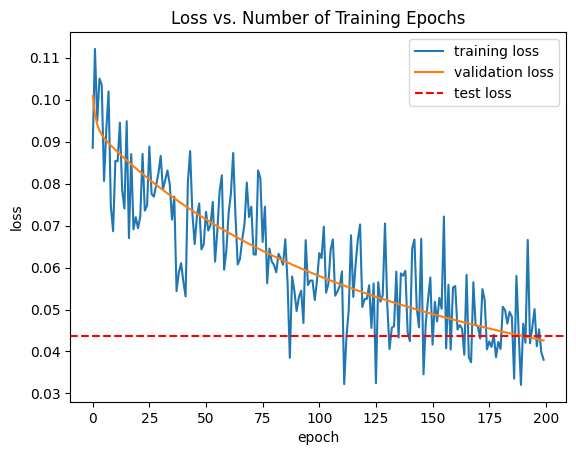

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Evaluate the model on the test set
with torch.no_grad():
    test_loss = 0.0
    for test_xb, test_yb in test_dl:
        test_pred = model(test_xb)
        test_loss += loss_fn(test_pred, test_yb).item()
    
    test_loss /= len(test_dl)
    print('Test Loss: {:.4f}'.format(test_loss))

# Plot loss and validation loss
fig, ax = plt.subplots()
ax.plot(loss_history, label='training loss')
ax.plot(validation_loss_history, label='validation loss')

ax.axhline(y=test_loss, color='r', linestyle='--', label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs. Number of Training Epochs')
ax.legend()
plt.show()

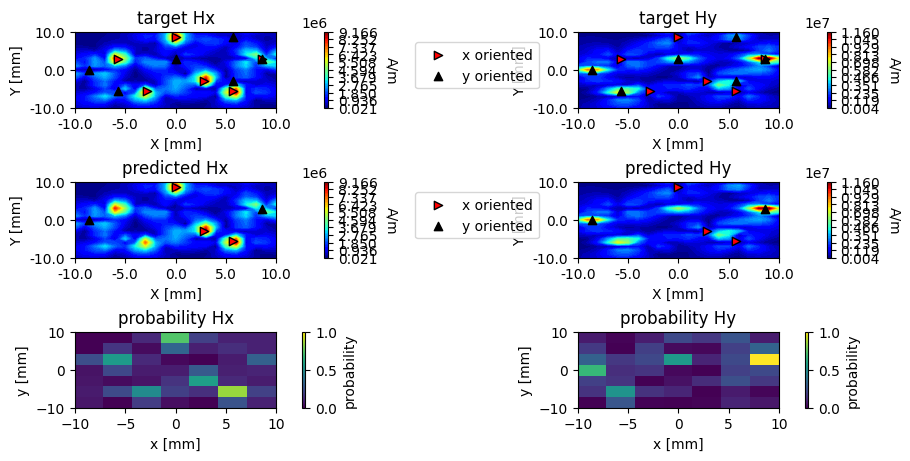

In [29]:
random_H, target = rmg.generate_labeled_data()
def predict(H, threshold=0.5, output_shape =None):
    # normalize H
    min_value = np.min(H)
    max_value = np.max(H)
    H = (H - min_value) / (max_value - min_value)

    H = np.expand_dims(H.flatten(), axis=0)
    H = torch.from_numpy(H).float()
    with torch.no_grad():
        pred = model(H)
    pred = pred.numpy().squeeze()
    if output_shape is not None:
        pred = pred.reshape(output_shape)
    # transform to probabilities
    # clip to zero minimum
    pred = np.clip(pred, 0, None)
    max_value = np.max(pred)
    min_value = np.min(pred)
    prob_pred = (pred - min_value) / (max_value - min_value)

    binarized_pred = np.zeros_like(pred)
    binarized_pred[pred > threshold] = 1
    pred = binarized_pred
    return pred, prob_pred

certainty = 0.4
prediction, pred_probability = predict(random_H, output_shape=(2,7,7), threshold=certainty)

fig, ax = plt.subplots(3,2, figsize=(9,4.5), constrained_layout=True)

# ax[1,0].pcolor(prediction[0])
rmg.plot_labeled_data(random_H, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
rmg.plot_labeled_data(random_H, prediction, ax=(ax[1,0], ax[1,1]))
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")

x_grid, y_grid, _ = rmg.generate_r0_grid()[..., 0]
q1 = ax[2,0].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[0], vmin=0, vmax=1)
q2 = ax[2,1].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[1], vmin=0, vmax=1)
ax[2,0].set_title("probability Hx")
ax[2,1].set_title("probability Hy")
ax[2,0].set_xlabel("x [mm]")
ax[2,1].set_xlabel("x [mm]")
ax[2,0].set_ylabel("y [mm]")
ax[2,1].set_ylabel("y [mm]")
cbar = fig.colorbar(q1, ax=ax[2,0], ticks=[0, 0.5, 1], label="probability")
cbar = fig.colorbar(q2, ax=ax[2,1], ticks=[0, 0.5, 1], label="probability")

# rmg.plot_labeled_data(random_H, prediction)

## Probabilistic Model

In [49]:
def fit(num_epochs, model, loss_fn, opt, train_dl, val_dl):
    loss_history = []  # List to store the loss values
    val_loss_history = []  # List to store the validation loss values
    
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = torch.sigmoid(model(xb))
            loss = loss_fn(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        # Append the loss value to the history list
        loss_history.append(loss.item())
        
        
        
        # Evaluate the model on the validation set
        with torch.no_grad():
            val_loss = 0.0
            for val_xb, val_yb in val_dl:
                val_pred = torch.sigmoid(model(val_xb))
                val_loss += loss_fn(val_pred, val_yb).item()
            
            val_loss /= len(val_dl)
            val_loss_history.append(val_loss)
        
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}, max_pred: {:.4f}'.format(epoch+1, num_epochs, loss.item(), val_loss, torch.max(pred)))
            
    return loss_history, val_loss_history


A = f.shape[1]
B = t.shape[1]
model = torch.nn.Linear(A, B)
loss_fn = torch.nn.BCELoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_history, validation_loss_history = fit(n_iterations, model, loss_fn, opt, train_dl, val_dl)

Epoch [10/200], Loss: 0.5028, Validation Loss: 0.5139, max_pred: 0.4280
Epoch [20/200], Loss: 0.4273, Validation Loss: 0.4329, max_pred: 0.3549
Epoch [30/200], Loss: 0.4077, Validation Loss: 0.3923, max_pred: 0.3341
Epoch [40/200], Loss: 0.3901, Validation Loss: 0.3698, max_pred: 0.3564
Epoch [50/200], Loss: 0.3538, Validation Loss: 0.3562, max_pred: 0.2312
Epoch [60/200], Loss: 0.3513, Validation Loss: 0.3474, max_pred: 0.3042
Epoch [70/200], Loss: 0.3402, Validation Loss: 0.3414, max_pred: 0.2643
Epoch [80/200], Loss: 0.3255, Validation Loss: 0.3370, max_pred: 0.2462
Epoch [90/200], Loss: 0.3177, Validation Loss: 0.3336, max_pred: 0.1979
Epoch [100/200], Loss: 0.3106, Validation Loss: 0.3310, max_pred: 0.2761
Epoch [110/200], Loss: 0.3397, Validation Loss: 0.3287, max_pred: 0.2344
Epoch [120/200], Loss: 0.3356, Validation Loss: 0.3268, max_pred: 0.2041
Epoch [130/200], Loss: 0.3185, Validation Loss: 0.3250, max_pred: 0.3155
Epoch [140/200], Loss: 0.3043, Validation Loss: 0.3234, max_

Test Loss: 0.3209


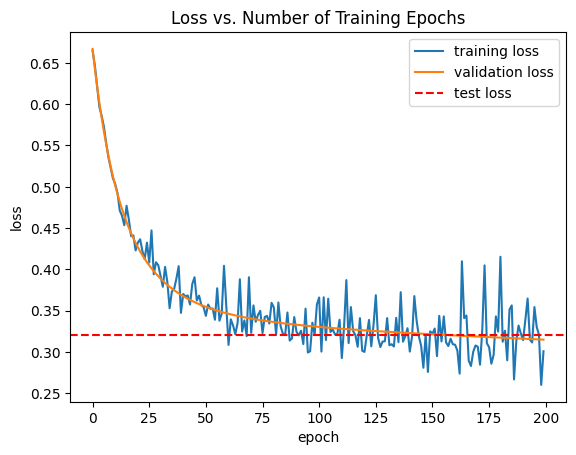

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

# Evaluate the model on the test set
with torch.no_grad():
    test_loss = 0.0
    for test_xb, test_yb in test_dl:
        test_pred = torch.sigmoid(model(test_xb))
        test_loss += loss_fn(test_pred, test_yb).item()
    
    test_loss /= len(test_dl)
    print('Test Loss: {:.4f}'.format(test_loss))

# Plot loss and validation loss
fig, ax = plt.subplots()
ax.plot(loss_history, label='training loss')
ax.plot(validation_loss_history, label='validation loss')

ax.axhline(y=test_loss, color='r', linestyle='--', label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs. Number of Training Epochs')
ax.legend()
plt.show()

In [69]:
random_H, target = rmg.generate_labeled_data()
norm_H = (random_H - np.min(random_H)) / (np.max(random_H) - np.min(random_H))

input = norm_H.reshape(1, -1)
input = torch.from_numpy(input).float()

with torch.no_grad():
    pred = torch.sigmoid(model(input))

p = pred.numpy().squeeze()
np.sum(p)

7.258828

max value:  0.14868827


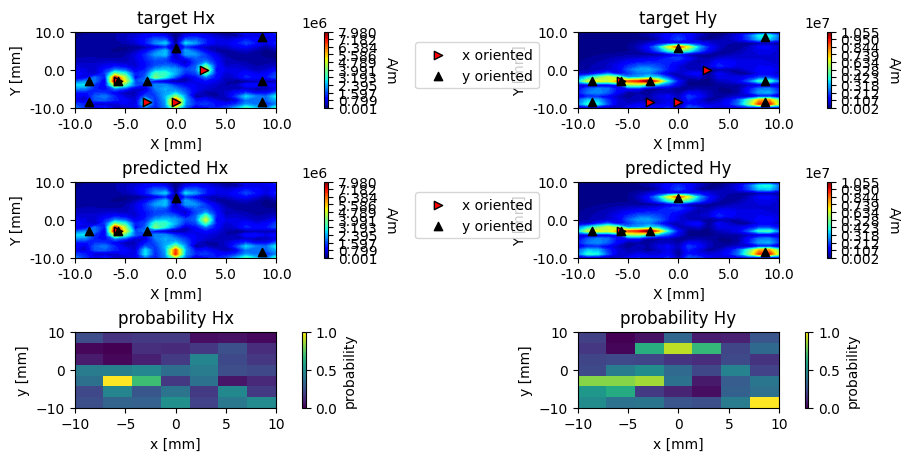

In [86]:
random_H, target = rmg.generate_labeled_data()
def predict(H, threshold=0.5, output_shape =None, normalize_predictions=True):
    # normalize H
    min_value = np.min(H)
    max_value = np.max(H)
    H = (H - min_value) / (max_value - min_value)

    H = np.expand_dims(H.flatten(), axis=0)
    H = torch.from_numpy(H).float()
    with torch.no_grad():
        pred = torch.sigmoid(model(H))
    pred = pred.numpy().squeeze()
    print("max value: ", np.max(pred))
    if output_shape is not None:
        pred = pred.reshape(output_shape)
    
    if normalize_predictions:
        # transform to probabilities
        # clip to zero minimum
        pred = np.clip(pred, 0, None)
        max_value = np.max(pred, axis=(1,2))
        min_value = np.min(pred, axis=(1,2))
        max_value = np.expand_dims(max_value, axis=(-1,-2))
        min_value = np.expand_dims(min_value, axis=(-1,-2))
        pred = (pred - min_value) / (max_value - min_value)
    # transform to probabilities
    # clip to zero minimum

    binarized_pred = np.zeros_like(pred)
    binarized_pred[pred > threshold] = 1
    return binarized_pred, pred

certainty = 0.7
prediction, pred_probability = predict(random_H, output_shape=(2,7,7), threshold=certainty)

fig, ax = plt.subplots(3,2, figsize=(9,4.5), constrained_layout=True)

# ax[1,0].pcolor(prediction[0])
rmg.plot_labeled_data(random_H, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
rmg.plot_labeled_data(random_H, prediction, ax=(ax[1,0], ax[1,1]))
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")

x_grid, y_grid, _ = rmg.generate_r0_grid()[..., 0]
q1 = ax[2,0].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[0], vmin=0, vmax=1)
q2 = ax[2,1].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[1], vmin=0, vmax=1)
ax[2,0].set_title("probability Hx")
ax[2,1].set_title("probability Hy")
ax[2,0].set_xlabel("x [mm]")
ax[2,1].set_xlabel("x [mm]")
ax[2,0].set_ylabel("y [mm]")
ax[2,1].set_ylabel("y [mm]")
cbar = fig.colorbar(q1, ax=ax[2,0], ticks=[0,0.5, 1], label="probability")
cbar = fig.colorbar(q2, ax=ax[2,1], ticks=[0,0.5,1], label="probability")

In [47]:
prediction

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)